In [1]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import cv2
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from collections import OrderedDict
import pyarrow.parquet as pa

2024-07-03 09:56:55.474303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 09:56:55.517249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 09:56:56.219144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#df for 64 embeddings
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_embeddings.pkl')

#df for 128 embeddings
# df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_128embeddings.pkl')

## Training the model

In [3]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [4]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

In [5]:
# data = np.load('data/magnatagatune/saved_df_data/data_array.npy')
data = np.load('/home/mendu/Thesis/data/magnatagatune/saved_df_data/data_array.npy')

In [6]:
# Caption Embeddings
embeddings = df['caption_embedding']

In [7]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255, 1)

In [8]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train_spec, X_val_spec, X_train_embed, X_val_embed, y_train, y_val = train_test_split(data, embeddings, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [9]:
# Now, convert this array of arrays into a proper 2D NumPy array
X_train_embed_array = np.stack(X_train_embed, axis=0)

# Check the new shape to ensure it's (450, 64)
print("Shape after conversion:", X_train_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_train_embed_tensor = tf.convert_to_tensor(X_train_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_train_embed_tensor.shape)

Shape after conversion: (10643, 64)
Tensor shape: (10643, 64)


2024-07-03 09:57:05.123648: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Convert the 1D array of arrays into a proper 2D NumPy array
X_val_embed_array = np.stack(X_val_embed, axis=0)

# Check the new shape to ensure it's in the correct format
print("Shape after conversion:", X_val_embed_array.shape)

# Convert the 2D NumPy array to a TensorFlow tensor
X_val_embed_tensor = tf.convert_to_tensor(X_val_embed_array, dtype=tf.float32)

# Check the shape of the resulting tensor
print("Tensor shape:", X_val_embed_tensor.shape)

Shape after conversion: (1183, 64)
Tensor shape: (1183, 64)


In [11]:
# Convert training data to tensors
X_train_spec = tf.convert_to_tensor(X_train_spec, dtype=tf.float32)
# X_train_embed = tf.convert_to_tensor(X_train_embed, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convert validation data to tensors
X_val_spec = tf.convert_to_tensor(X_val_spec, dtype=tf.float32)
# X_val_embed = tf.convert_to_tensor(X_val_embed, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [12]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train_spec)

In [13]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

8

In [14]:
data.shape

(11826, 128, 1255, 1)

In [15]:
class ModelSubClassing(keras.Model):
    def __init__(self, num_classes, l1_reg=0.001, l2_reg=0.01, alpha = 0.001):
        super().__init__()
        
        # Define L1 and L2 regularizer
        self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        # self.l2_regularizer = regularizers.l2(l2_reg)
        
        # Define alpha the loss regulator
        self.alpha = alpha
        
        # number of classes
        self.num_classes = num_classes
        
        # Initialize layers as None
        self.conv1 = None
        self.max1 = None
        self.bn1 = None
        self.conv2 = None
        self.bn2 = None
        self.max2 = None
        self.drop1 = None
        self.conv3 = None
        self.bn3 = None
        self.max3 = None
        self.drop2 = None
        self.flatten = None
        self.dense128 = None
        self.dense128_activation = None
        self.dense128_do = None
        self.dense64 = None
        self.dense64_activation = None
        self.dense_out = None
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        # self.mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

        #new
        self.accuracy = keras.metrics.CategoricalAccuracy(name="accuracy")
        
        

    def build(self, input_shape):
        # Create layers
        self.conv1 = Conv2D(32, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.max1  = MaxPooling2D(3)
        self.bn1   = BatchNormalization(momentum=0.9)

        self.conv2 = Conv2D(64, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn2   = BatchNormalization(momentum=0.9)
        self.max2  = MaxPooling2D(3)
        self.drop1 = Dropout(0.3)

        self.conv3 = Conv2D(128, 3, activation="relu", kernel_regularizer=self.l1_l2_regularizer)
        self.bn3   = BatchNormalization(momentum=0.9)
        self.max3  = MaxPooling2D(3)
        self.drop2 = Dropout(0.3)

        self.flatten = Flatten()
        self.dense128 = Dense(128)
        self.dense128_activation = Activation('relu')
        self.dense128_do = Dropout(0.3)
        self.dense64 = Dense(64)
        self.dense64_activation = Activation('relu')
        self.dense_out = Dense(self.num_classes, activation="softmax")
        
        super().build(input_shape)

    def call(self, inputs, training=None):
        # Unpack the inputs
        mel_spectrogram = inputs[0]

        # Forward pass: block 1
        x = self.conv1(mel_spectrogram)
        x = self.max1(x)
        x = self.bn1(x, training=training)

        # Forward pass: block 2
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.max2(x)
        x = self.drop1(x, training=training)

        # Forward pass: block 3
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.max3(x)
        x = self.drop2(x, training=training)

        # Flatten and dense layers
        x = self.flatten(x)
        x_dense128 = self.dense128(x)
        x_dense128_act = self.dense128_activation(x_dense128)
        x_dense128_act = self.dense128_do(x_dense128_act)
        x_dense64 = self.dense64(x_dense128_act)
        x_dense64_act = self.dense64_activation(x_dense64)
        y_hat = self.dense_out(x_dense64_act)
        
        return y_hat, x_dense64


    def train_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        with tf.GradientTape() as tape: 
        #here we get the gradients of the trainable weights with this loss
            y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=True)  # Forward pass
            # Compute the standard loss value
            loss = self.compiled_loss(y, y_pred)
            custom_loss = self.custom_loss(caption_embedding, x_dense64)
            total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

        # Compute gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)

        # Update weights
        # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss) #this is different
        
        #old
        # for metric in self.metrics:
        #     metric.update_state(y, y_pred)

        # return {
        #     "loss": self.loss_tracker.result(),
        #     # "mae": self.mae_metric.result(),
        #     **{m.name: m.result() for m in self.metrics},
        # }
        
        #new
        self.accuracy.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy.result(),
            "crossentropy_loss": loss,
            "embedding_loss": custom_loss,
            "total_loss": total_loss
        }

        
    def test_step(self, data):
        # Unpack the data
        (mel_spectrogram, caption_embedding), y = data

        
        y_pred, x_dense64 = self((mel_spectrogram, caption_embedding), training=False)  # Forward pass
        # Compute the standard loss value
        loss = self.compiled_loss(y, y_pred)
        custom_loss = self.custom_loss(caption_embedding, x_dense64)
        total_loss = (1 - self.alpha) * loss + self.alpha * custom_loss

        # Update the loss metric and any additional metrics
        self.loss_tracker.update_state(total_loss)
        
        #old
        # for metric in self.metrics:
        #     metric.update_state(y, y_pred)

        # return {
        #     "loss": self.loss_tracker.result(),
        #     # "mae": self.mae_metric.result(),
        #     **{m.name: m.result() for m in self.metrics},
        # }
        
        #new
        self.accuracy.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy.result(),
            "crossentropy_loss": loss,
            "embedding_loss": custom_loss,
            "total_loss": total_loss
        }
        
    # Add a custom loss method in the model
    def custom_loss(self, caption_embedding, x_dense64):
        return tf.reduce_mean(tf.square(caption_embedding - x_dense64))

    #new
    @property
    def metrics(self):
        # List all metrics to be reset after each epoch
        return [self.loss_tracker, self.accuracy]
    
# Creating the class object
model = ModelSubClassing(num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    (X_train_spec, X_train_embed_tensor),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=((X_val_spec, X_val_embed_tensor), y_val),
    callbacks = [early_stopper]
)

Epoch 1/100


/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:612: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(


333/333 ━━━━━━━━━━━━━━━━━━━━ 114s 334ms/step - accuracy: 0.4250 - crossentropy_loss: 3.5858 - embedding_loss: 9370.6230 - loss: 15.2035 - total_loss: 12.9529 - val_accuracy: 0.2654 - val_loss: 124.3323
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 110s 331ms/step - accuracy: 0.5073 - crossentropy_loss: 2.5762 - embedding_loss: 4698.1670 - loss: 8.0490 - total_loss: 7.2718 - val_accuracy: 0.4472 - val_loss: 7.5493
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 110s 332ms/step - accuracy: 0.5633 - crossentropy_loss: 2.1965 - embedding_loss: 3459.4124 - loss: 5.9185 - total_loss: 5.6537 - val_accuracy: 0.2654 - val_loss: 24.4725
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 110s 331ms/step - accuracy: 0.5862 - crossentropy_loss: 2.0430 - embedding_loss: 3041.9534 - loss: 5.2204 - total_loss: 5.0829 - val_accuracy: 0.1733 - val_loss: 15.3926
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 110s 331ms/step - accuracy: 0.6277 - crossentropy_loss: 1.8495 - embedding_loss: 2760.6028 - loss: 4.6652 - total_loss: 4.608

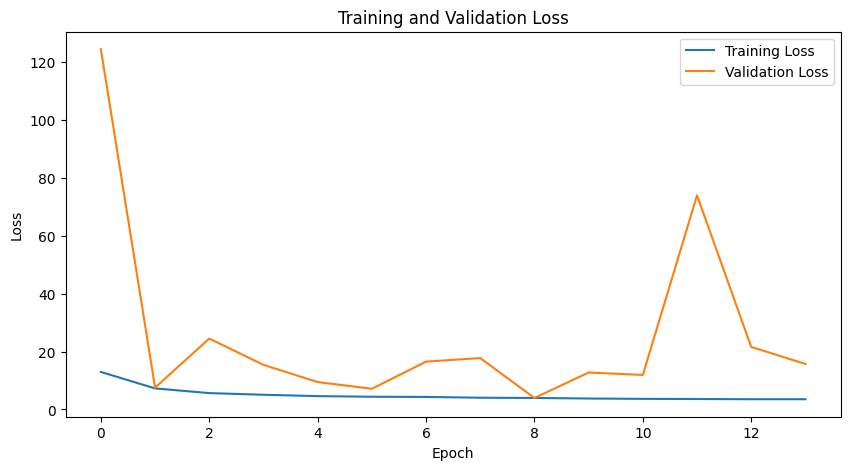

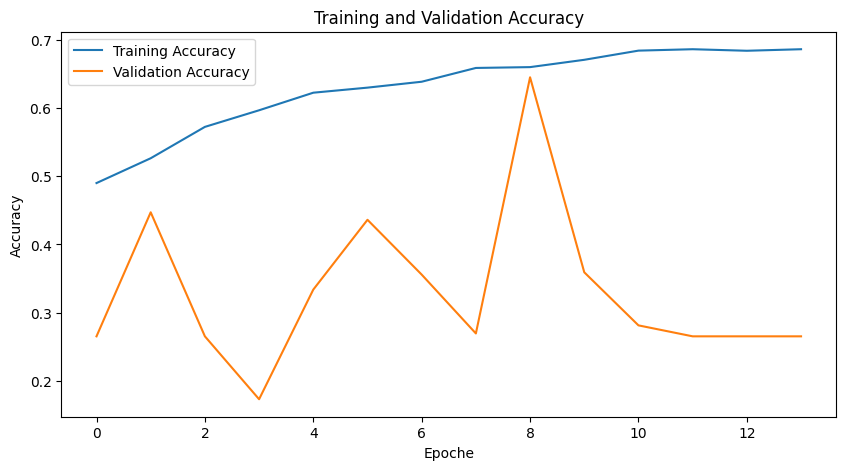

In [17]:
# Plot a graph for training and validation loss
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a graph for training and validation accuracy
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


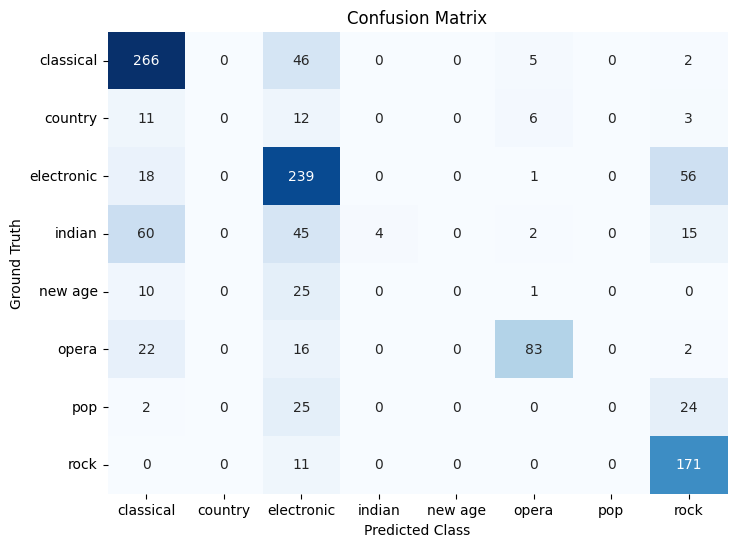

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predictions = model.predict((X_val_spec, X_val_embed_tensor))
predicted_labels = np.argmax(predictions[0], axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

# Define class labels
class_labels = ['classical', 'country', 'electronic', 'indian',
                'new age', 'opera', 'pop', 'rock']

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Create a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


In [19]:
# Correctly structure the evaluation data
val_data = ((X_val_spec, X_val_embed_tensor), y_val)
train_data = ((X_train_spec, X_train_embed_tensor), y_train)

# Evaluate on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(train_data)
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Correctly structure the evaluation data
val_data = ((X_val_spec, X_val_embed_tensor), y_val)
train_data = ((X_train_spec, X_train_embed_tensor), y_train)

# Evaluate on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(train_data)
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# last val loss and val acc
val_loss, val_accuracy = model.evaluate(X_val_spec, X_val_embed_tensor, y_val)
train_loss, train_accuracy = model.evaluate((X_train_spec, X_train_embed_tensor), y_train)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()